In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import librosa
import librosa.display

import tensorflow.keras as keras
from keras import Sequential
from keras import applications

2022-05-05 18:03:12.716547: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-05-05 18:03:12.716574: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
MELSPECTROGRAM_PATH = 'pkl_files/mel_spectrogram.npy'
TARGET_PATH = 'pkl_files/target.csv'
SIGNAL_PATH = 'pkl_files/audio.npy'
MELSPECTROGRAM_MODEL = 'models/melspec_model.h5'

In [3]:
def build_model(input_shape):
    model = Sequential()
    
    # features extracting layers
    # conv 1 + maxpool
    model.add(keras.layers.Conv2D(8, (3, 3), activation='relu', input_shape=input_shape))
    model.add(keras.layers.MaxPooling2D((2, 2), strides=(2, 2), padding='valid'))
    model.add(keras.layers.BatchNormalization())
    
    # conv 2 + maxpool
    model.add(keras.layers.Conv2D(32, (3, 3), activation='relu'))
    model.add(keras.layers.MaxPooling2D((2, 2), strides=(2, 2), padding='valid'))
    model.add(keras.layers.BatchNormalization())
    
    # conv 3 + maxpool
    model.add(keras.layers.Conv2D(64, (2, 2), activation='relu'))
    model.add(keras.layers.MaxPooling2D((2, 2), strides=(2, 2), padding='valid'))
    model.add(keras.layers.BatchNormalization())
    
    
    # Flatten layer + classification layer
    model.add(keras.layers.Flatten())
    
    model.add(keras.layers.Dense(units=200, activation='relu'))
    model.add(keras.layers.Dropout(rate=0.25))
    
    model.add(keras.layers.Dense(units=128, activation='relu'))
    model.add(keras.layers.Dropout(rate=0.25))
    
    # output layer
    model.add(keras.layers.Dense(units=8, activation='softmax'))
    
    return model

In [4]:
melspec = np.load(MELSPECTROGRAM_PATH, allow_pickle=True)

In [6]:
y = pd.read_csv(TARGET_PATH, names=['target'])

In [7]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y = le.fit_transform(y)
labels = le.classes_

/home/mahmoud/.local/lib/python3.8/site-packages/sklearn/utils/validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


In [8]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(melspec, y, test_size=0.2, random_state=101)

# Train Model

In [9]:
VERBOSE = 1
EPOCHS = 30
BATCH = 32

In [10]:
model = build_model(melspec.shape[1:])
model.summary()

2022-05-05 18:04:16.256792: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-05 18:04:16.257356: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-05-05 18:04:16.257460: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublas.so.11'; dlerror: libcublas.so.11: cannot open shared object file: No such file or directory
2022-05-05 18:04:16.257550: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublasLt.so.11'; dlerror: libcublasLt.so.11: cannot open shared object file: No such file or directory
2022-05-05 18:04:16.257642: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Co

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 126, 42, 8)        80        
                                                                 
 max_pooling2d (MaxPooling2D  (None, 63, 21, 8)        0         
 )                                                               
                                                                 
 batch_normalization (BatchN  (None, 63, 21, 8)        32        
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 61, 19, 32)        2336      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 30, 9, 32)        0         
 2D)                                                             
                                                        

In [35]:
es = keras.callbacks.EarlyStopping(monitor='val_loss'
                                   , mode='min'
                                   , verbose=VERPOSE
                                   , patience=10
                                   , min_delta=0.0001)

mc = keras.callbacks.ModelCheckpoint('best_model.hdf5'
                                     , monitor='val_acc'
                                     , verbose=VERPOSE
                                     , save_best_only=True
                                     , mode='max')

In [36]:
model.compile(loss='SparseCategoricalCrossentropy',optimizer='adam',metrics=['accuracy'])

In [37]:
history=model.fit(X_train, y_train 
                  , epochs=EPOCHS, batch_size=BATCH_SIZE
                  , validation_data=(X_test,y_test)
                  , callbacks=[es,mc])

Epoch 1/100
764/764 [==============================] - 37s 47ms/step - loss: 1.5403 - accuracy: 0.4500 - val_loss: 1.7633 - val_accuracy: 0.3702
Epoch 2/100
764/764 [==============================] - 35s 46ms/step - loss: 0.7374 - accuracy: 0.7452 - val_loss: 1.0950 - val_accuracy: 0.6170
Epoch 3/100
764/764 [==============================] - 35s 46ms/step - loss: 0.5125 - accuracy: 0.8282 - val_loss: 0.7776 - val_accuracy: 0.7464
Epoch 4/100
764/764 [==============================] - 35s 46ms/step - loss: 0.3977 - accuracy: 0.8629 - val_loss: 1.0601 - val_accuracy: 0.6700
Epoch 5/100
764/764 [==============================] - 35s 46ms/step - loss: 0.3342 - accuracy: 0.8863 - val_loss: 0.8542 - val_accuracy: 0.7469
Epoch 6/100
764/764 [==============================] - 37s 49ms/step - loss: 0.2910 - accuracy: 0.8997 - val_loss: 0.4772 - val_accuracy: 0.8381
Epoch 7/100
764/764 [==============================] - 34s 45ms/step - loss: 0.2584 - accuracy: 0.9107 - val_loss: 0.4515 - val_ac

Epoch 28/100
764/764 [==============================] - 34s 44ms/step - loss: 0.0778 - accuracy: 0.9757 - val_loss: 0.7309 - val_accuracy: 0.8343
Epoch 29/100
764/764 [==============================] - 34s 44ms/step - loss: 0.0725 - accuracy: 0.9758 - val_loss: 0.4599 - val_accuracy: 0.8999
Epoch 30/100
764/764 [==============================] - 34s 45ms/step - loss: 0.0748 - accuracy: 0.9765 - val_loss: 0.4110 - val_accuracy: 0.9130
Epoch 30: early stopping


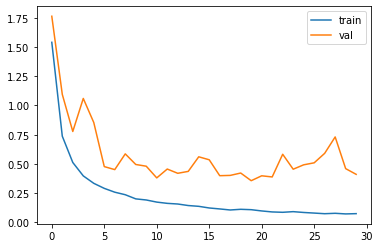

In [44]:
fig, axs = plt.subplots(1, 2, figsize=(20, 5))
axs[0].plot(history.history['loss'], label='train')

axs[0].plot(history.history['val_loss'], label='val')
axs[0].set_title('loss')
axs[0].legend()
axs[1].plot(history.history['accuracy'], label='train')

axs[1].plot(history.history['val_accuracy'], label='val')
axs[1].set_title('accuracy')
axs[1].legend()
plt.show()

# Test model with real audios

In [45]:
import pyaudio
import wave
import IPython.display as ipd

In [133]:
RATE = 22050
CHUNK = 1024
FORMAT = pyaudio.paInt16
CHANNELS = 1

p = pyaudio.PyAudio()

stream = p.open(format=FORMAT
               ,channels=CHANNELS
               ,rate=RATE
               ,input=True
               ,frames_per_buffer=CHUNK)
print('start recording')
frames = []
seconds = 1.0
for i in range(int(RATE/CHUNK * seconds)):
    data = stream.read(CHUNK)
    frames.append(data)
print('end recording')
stream.stop_stream()
stream.close()
p.terminate()


wf = wave.open('input.wav', 'wb')
wf.setnchannels(CHANNELS)
wf.setsampwidth(p.get_sample_size(FORMAT))
wf.setframerate(RATE)
wf.writeframes(b''.join(frames))
wf.close()


ipd.Audio('input.wav')

ALSA lib pcm_dsnoop.c:641:(snd_pcm_dsnoop_open) unable to open slave
ALSA lib pcm_dmix.c:1089:(snd_pcm_dmix_open) unable to open slave
ALSA lib pcm.c:2642:(snd_pcm_open_noupdate) Unknown PCM cards.pcm.rear
ALSA lib pcm.c:2642:(snd_pcm_open_noupdate) Unknown PCM cards.pcm.center_lfe
ALSA lib pcm.c:2642:(snd_pcm_open_noupdate) Unknown PCM cards.pcm.side
ALSA lib pcm_oss.c:377:(_snd_pcm_oss_open) Unknown field port
ALSA lib pcm_oss.c:377:(_snd_pcm_oss_open) Unknown field port
ALSA lib pcm_usb_stream.c:486:(_snd_pcm_usb_stream_open) Invalid type for card
ALSA lib pcm_usb_stream.c:486:(_snd_pcm_usb_stream_open) Invalid type for card
ALSA lib pcm_dmix.c:1089:(snd_pcm_dmix_open) unable to open slave


start recording
end recording


In [136]:
live_audio = 'input.wav'

signal, _ = librosa.load(live_audio, sr=22050)
signal = np.append(signal, np.zeros(22050-len(signal)))

signal = librosa.feature.melspectrogram(signal)
signal = signal[np.newaxis, ..., np.newaxis]
le.inverse_transform([model.predict(signal).argmax()])

/tmp/ipykernel_9968/2650480416.py:4: FutureWarning: Pass y=[ 0.00000000e+00  3.05175781e-05 -9.15527344e-05 ...  0.00000000e+00
  0.00000000e+00  0.00000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  signal = librosa.feature.melspectrogram(signal)


array(['stop'], dtype=object)

In [137]:
model.save(MELSPECTROGRAM_MODEL)